# Integration

In [1]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

## Simple Integration... Let's start with just 1D integral

### Data Generation

In [2]:
data = np.load('toy_data_10e4.npz')

In [3]:
Xdata = data['xdata']
print(Xdata)

[[2.55258737 0.41757623 2.5810235  0.        ]
 [1.05945455 2.73902844 2.59982768 0.01002004]
 [2.71202945 3.38179615 1.0272925  0.02004008]
 ...
 [2.26058831 2.62355914 0.18093676 4.97995992]
 [2.91426381 3.41772047 2.93088925 4.98997996]
 [0.1022243  2.0529486  1.72946409 5.        ]]


In [4]:
Ydata = data['ydata']
print(Ydata)

[-0.03413077  0.00653628 -0.83397146 ...  0.9999308  -0.8789377
 -0.79724696]


### Target function

### Circuit Model

In [7]:
dev_stochastic = qml.device("lightning.qubit", wires=10)

@qml.qnode(dev_stochastic, diff_method="parameter-shift")
def single_data_point_ansatz(params, phis, x, num_layers):
    """
    Quantum Circuit Model for a single data point x.

    INPUT
    params : array of theta parameters
    phis : array of phi for the last rotation gate
    x : single data point for reuploading

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    num_qubits = math.ceil(len(x) / 2)
    param_index = 0

    for _ in range(num_layers):
        for i in range(len(x)):
            qubit = i // 2
            qml.RY(params[param_index], wires=qubit)
            qml.RZ(params[param_index + 1], wires=qubit)
            qml.RZ(x[i], wires=qubit)  # Re-uploading data here
            qml.RY(params[param_index + 2], wires=qubit)
            qml.RZ(params[param_index + 3], wires=qubit)
            param_index += 4
        
        if num_qubits > 1:
            for q in range(0, num_qubits - 1, 1):
                qml.CZ(wires=[q, q + 1])
            if num_qubits > 2:
                qml.CZ(wires=[num_qubits - 1, 0])
    
    for i in range(num_qubits): 
        qml.RY(phis[i], wires=i)

    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)
    
    return qml.expval(obs)


def batch_ansatz(params, phis, xdata, num_layers):
    """
    Quantum Circuit Model for batch data.

    INPUT
    params : array of theta parameters
    phis : array of phi for the last rotation gate
    xdata : batch of data points for reuploading
    num_layers : layers we will append for the circuit

    OUTPUT
    Mean of expectation values with PauliZ measure over the batch
    """
    # Ensure that `params` is a flat list for single_data_point_ansatz
    flat_params = params.flatten()
    
    # Calculate the expectation for each data point and take the mean
    expectations = [single_data_point_ansatz(flat_params, phis, x, num_layers) for x in xdata]
    return np.mean(expectations)

/home/kban/.local/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


[0.17827215 0.57666515 0.67513005 0.81846239 0.93932721 0.26357393
 0.20275885 0.8592312  0.26100854 0.95916566 0.73823606 0.98867133
 0.76168891 0.55937236 0.12678064 0.04602907 0.97936243 0.6393217
 0.28326717 0.56462284 0.10534565 0.62418791 0.02774595 0.26683968
 0.78912964 0.00125882 0.32445339 0.46856635 0.12562493 0.47928415
 0.82211142 0.70636646 0.26782975 0.17742842 0.47312994 0.9278913
 0.11108655 0.2551302  0.12350515 0.27610254]


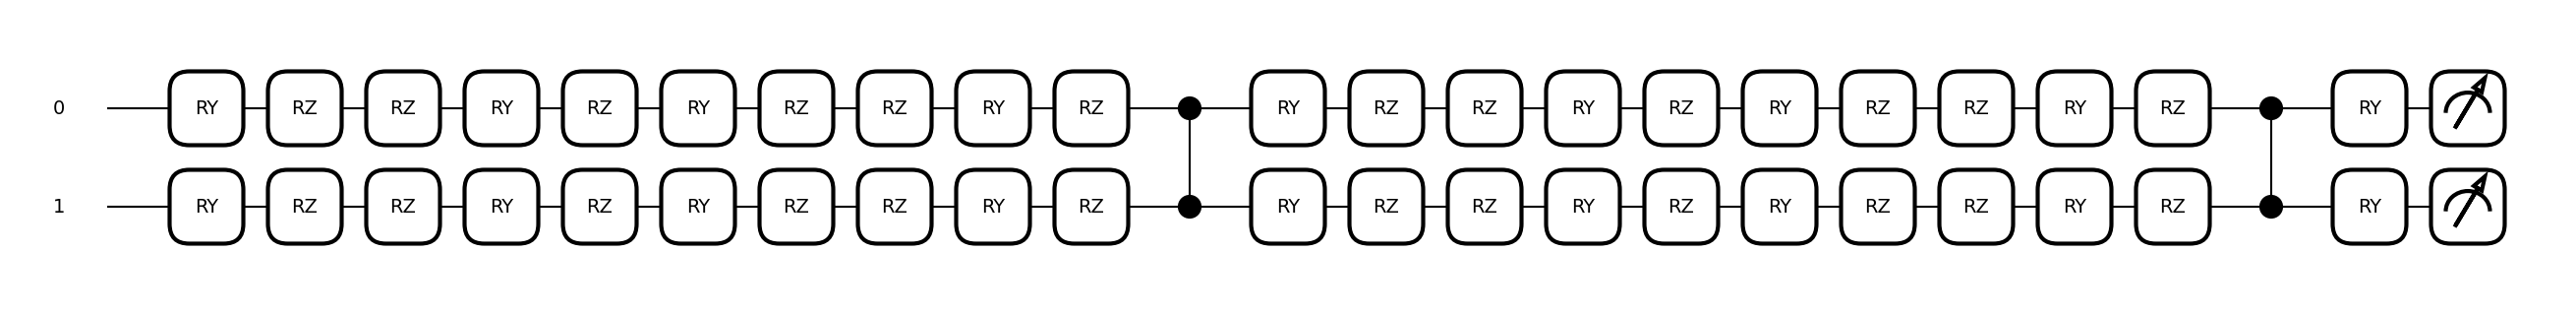

In [8]:
xdim = 4
num_qubits = math.ceil(xdim / 2)
num_layers = 2

xdata = Xdata[:100] #np.random.uniform(size = [100,xdim], requires_grad=False)
thetas = np.random.uniform(size = xdim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size=(num_qubits,1), requires_grad =True)
target = Ydata[:100]
print(thetas)

params = 0
params += thetas
param_index = 1
for _ in range(num_layers):
    for j in range(xdim):
        params[param_index] = thetas[param_index] * xdata[0][j]
        param_index += 5

fig, ax = qml.draw_mpl(single_data_point_ansatz)(params, phis, xdata[0], num_layers)
plt.show()

### Loss function

In [9]:
from scipy.optimize import minimize

In [10]:
# 손실 함수 정의
def cost_function(params, phis, xdata, target, num_layers):
    # 손실 계산을 위해 batch_ansatz를 사용합니다.
    predictions = batch_ansatz(params, phis, xdata, num_layers)
    loss = np.mean((predictions - target)**2)
    return loss

# 수동 그라디언트 계산 함수
def parameter_shift_term(qnode, params, i, phis, xdata, num_layers):
    shifted_params = params.copy()
    shift = np.pi / 2
    
    # 각 파라미터에 대한 기울기를 계산합니다.
    shifted_params = params.copy()
    shifted_params[i] += shift
    forward = [qnode(shifted_params, phis, x, num_layers) for x in xdata]  # Forward evaluation

    shifted_params[i] -= 2 * shift
    backward = [qnode(shifted_params, phis, x, num_layers) for x in xdata]  # Backward evaluation

    # 배치 기대값의 평균을 구하여 기울기를 계산합니다.
    gradient = np.mean([(f - b) / (2 * np.sin(shift)) for f, b in zip(forward, backward)])
    return gradient

# 파라미터 업데이트 함수
def update_params(params, grads, learning_rate=0.01):
    new_params = params - learning_rate * grads
    return new_params


In [12]:
# 학습 설정
epochs = 100
learning_rate = 0.001


# 학습 루프
for epoch in range(epochs):
    # 그라디언트를 저장할 배열 초기화
    grads = np.zeros_like(params.flatten())  # params.flatten()으로 모든 파라미터에 대한 평평한 배열 생성

    # 모든 파라미터에 대해 그라디언트 계산
    for i in range(len(params.flatten())):
        # 각 파라미터에 대한 기울기 계산
        grads[i] = parameter_shift_term(single_data_point_ansatz, params, i, phis, xdata, num_layers)
    
    # 그라디언트의 모양을 원래 params의 모양으로 재구성
    grads = grads.reshape(params.shape)
    
    # 파라미터 업데이트
    params = update_params(params, grads, learning_rate)

    # 손실 계산
    loss = cost_function(params, phis, xdata, target, num_layers)
    print(f"Epoch {epoch+1}, Loss: {loss}")

# 최종 파라미터 출력
print("최적화된 파라미터:", params)


Epoch 1, Loss: 0.52488411646778
Epoch 2, Loss: 0.5246270315447856
Epoch 3, Loss: 0.5243728564555415
Epoch 4, Loss: 0.5241215977913665
Epoch 5, Loss: 0.5238732620573885
Epoch 6, Loss: 0.5236278556720805
Epoch 7, Loss: 0.5233853849668008
Epoch 8, Loss: 0.5231458561853439
Epoch 9, Loss: 0.5229092754834932
Epoch 10, Loss: 0.5226756489285845
Epoch 11, Loss: 0.5224449824990738
Epoch 12, Loss: 0.5222172820841131
Epoch 13, Loss: 0.5219925534831327
Epoch 14, Loss: 0.5217708024054305
Epoch 15, Loss: 0.5215520344697694
Epoch 16, Loss: 0.521336255203979
Epoch 17, Loss: 0.521123470044568
Epoch 18, Loss: 0.5209136843363408
Epoch 19, Loss: 0.5207069033320231
Epoch 20, Loss: 0.5205031321918939
Epoch 21, Loss: 0.5203023759834255
Epoch 22, Loss: 0.5201046396809305
Epoch 23, Loss: 0.5199099281652153
Epoch 24, Loss: 0.5197182462232437
Epoch 25, Loss: 0.5195295985478046
Epoch 26, Loss: 0.5193439897371901
Epoch 27, Loss: 0.5191614242948795
Epoch 28, Loss: 0.5189819066292324
Epoch 29, Loss: 0.518805441053186

In [114]:
# 학습 설정
epochs = 100
learning_rate = 0.01


# 학습 루프
for epoch in range(epochs):
    # 그라디언트를 저장할 배열 초기화
    grads = np.zeros_like(params.flatten())  # params.flatten()으로 모든 파라미터에 대한 평평한 배열 생성

    # 모든 파라미터에 대해 그라디언트 계산
    for i in range(len(params.flatten())):
        # 각 파라미터에 대한 기울기 계산
        grads[i] = parameter_shift_term(single_data_point_ansatz, params, i, phis, xdata, num_layers)
    
    # 그라디언트의 모양을 원래 params의 모양으로 재구성
    grads = grads.reshape(params.shape)
    
    # 파라미터 업데이트    
    params = params.flatten()
    target = target.flatten()

    # Using Scipy's minimize function with the LBFGS method
    result = minimize(cost_function, params, args=(xdata, target), method='L-BFGS-B')

    # Extract the optimized parameters
    params = result.x
    

    # 손실 계산
    loss = cost_function(params, phis, xdata, target, num_layers)
    print(f"Epoch {epoch+1}, Loss: {loss}")

# 최종 파라미터 출력
print("최적화된 파라미터:", params)


TypeError: cost_function() missing 2 required positional arguments: 'target' and 'num_layers'

In [9]:
xdim = 4
num_qubits = math.ceil(xdim / 2)
num_layers = 1

xdata = np.random.uniform(size=(1, xdim), requires_grad=False)
thetas = np.random.uniform(size=xdim*num_layers*5, requires_grad=True)
phis = np.random.uniform(size=(num_qubits,1), requires_grad =True)

params = 0
params += thetas


for i in range(len(Xdata)):
    param_index = 1
    for _ in range(num_layers):
        for j in range(xdim):
            params[param_index] = thetas[param_index] * Xdata[i][j]
            param_index += 5

    # print(Ansatz(params, phis, xdim, num_layers))

In [10]:
def parameter_shift_term(qnode, params, x_i, phis, xdim, num_layers):
    """
    Basic Parameter shift rule for each x_i i= 0,1, ..., xdim
   
    INPUT
    qnode :  circuit ansatz we designed
    parmas : (array) of parameters we put in the circuit
    x_i : (int) ${{\partial f(\theta)} \over {\partial x_i}}$
    phis : (array) the last parameters of the circuit
    ndim : (int) dimenstion of $\vec{x}$
    num_layers : (int) number of layer we make for the model

    OUTPUT
    expectation value where we apply the Basic PSR for the circuit
    """

    shifted = params.copy()
    i = x_i*5
    for _ in range(num_layers):

        shifted[i: i+5] += np.pi/2
        forward = qnode(shifted, phis, xdim, num_layers)  # forward evaluation

        shifted[i: i+5] -= np.pi/2
        backward = qnode(shifted, phis, xdim, num_layers) # backward evaluation
        
        i += xdim*5

    return 0.5 * (forward - backward)

# gradient with respect to  x_0
print(parameter_shift_term(Ansatz, params, 0, phis, xdim, num_layers))

[-0.13852134]


In [11]:
def parameter_shift(qnode, params, phis, xdim, num_layers):
    """
    PSR applying to the whole circuit and getting the gradient vector as array

    INPUT
    qnode : circuit model
    params : parameters that are in the circuit except the last layer
    phis : parameters for the last RY gate
    xdim : dimension of $\vec{x}$
    num_layers : number of layers

    OUTPUT
    gradient vector of the quantum circuit
    """
    gradients = np.zeros([xdim])

    for i in range(xdim):
        gradients[i] = parameter_shift_term(qnode, params, i, phis, xdim, num_layers)

    return gradients

print(parameter_shift(Ansatz, params, phis, xdim, num_layers))

[-0.13852134 -0.10568801  0.0054801   0.11752005]


In [12]:
def loss_function(qnode = Ansatz, thetas, phis, xdata=Xdata[0], xdim, num_layers, target):
    """
    loss function

    INPUT
    

    OUTPUT
    loss with MSE
    """
    
    params = 0
    params += thetas
    param_index = 1

    for _ in range(num_layers):
        for j in range(xdim):
            params[param_index] = thetas[param_index] * xdata[j]
            param_index += 5


    gradient = parameter_shift(Ansatz, params, phis, xdim, num_layers)
    
    


SyntaxError: non-default argument follows default argument (4069589838.py, line 1)